# 課題　卸売業者 教師なし学習

## 【課題】教師なし学習とは何か記述せよ
データを扱う前に、教師なし学習への理解の確認です。以下の観点を含めて文章で記述しましょう。以降の設問も含め、インターネットや書籍で調べても構いません。

- 教師あり学習との比較
- どんなときに使うのか
- 具体的にどんなものがあるのか

## 答え：
### 教師あり学習との比較
何らかの目標や基準を与えられ、出力するべきものが予め決められているのが教師あり学習。特定の目標や基準を与えられず、出力するべきものが予め決められていないのが教師あり学習
### どんなときに使うのか
データの背後に存在する、まだ明らかになっていない本質的な構造を抽出したいような場合に用いられる。ただし、結果が有意義になる保証はなく、何らかの目的に対して有用であるとは限らない
### 具体的にどんなものがあるのか
クラスター分析、特徴選択、主成分分析、ガウス混合分布モデル、多様体学習、バイクラスタリング、など

## 【課題】必要なライブラリをimport

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

import seaborn as sns

from sklearn.decomposition import PCA

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import KMeans

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

## 【課題】csvファイルの読み込み

In [2]:
#csvを読み込むコードを記述
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv')

print("サンプルの数：{} 　特徴量の数：{}\n".format(*data.shape))
print("各特徴量の型\n",data.dtypes,"\n")
print("統計量の要約")
display(data.describe())
display(data.head())

サンプルの数：440 　特徴量の数：8

各特徴量の型
 Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object 

統計量の要約


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 【課題】不要な特徴量を消す
データを眺めてみた結果、ChannelとRegionは他の６つと異なるタイプのデータのようです。

UCIのページも参考にしてみると、ChannelにはHoreca(1)またはRetail(2)というラベルが入っていることが分かります。 Horecaは食品業界の用語で「Hotel/Restaurant/Café」の略称、Retailは小売店の意味です。 また、Regionは顧客の地域のデータで、Lisbon(1)、Oporto(2) 、Other Region(3)のラベルです。首都リスボン、第二の都市ポルト、その他の地域です。

これら２つは既にグループを表していると言えます。今回のクラスタリングではChannelとRegionを消し、年間の購入金額についての6つの特徴量だけを使うことにします。 地域や業種といった人間にとって明確なグループとは異なる分け方があるのかを探りたいからです。

In [3]:
#元のデータはdata_originalに格納しておく
data_original = data.copy()

#dataからChannelとRegionの2列を削除するコードを記述
data = data.drop(['Channel', 'Region'], axis=1)

#消えていることを確認
display(data.head())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b92ab00>,
      dtype=object)

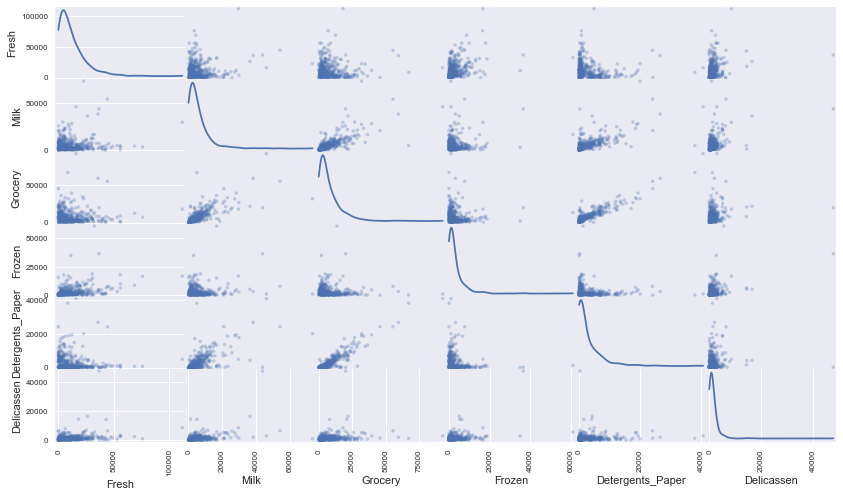

In [4]:
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

## 【課題】Feature Scalingの実行
このあとはPCA（Feature Extraction）を行いますが、そのためにはFeature Scalingの作業が必要でした。

テキストでは標準化と正規化を学びましたが、ここでは自然対数（log)を使いScalingを行います。
dataに対して処理を行い、data_fsに格納してください。
（ヒント：logへの変換はnumpyで簡単にできます）

In [5]:
#dataに対して適切なFeature Scalingを行うコードを記述
data_fs = np.log1p(data)

## 【課題】なぜFeature Scalingが必要なのか記述せよ
Feature Scalingを行う理由とはなんでしょう。文章で記述してください。
scatter matrixがどのように変化したか見るのも良いでしょう。

## 答え：
n個の特徴量をPCAする場合、データをn次元座標軸上の楕円体と捉える。楕円体の長い軸を新しい特徴量と考えて、不要になる座標軸を減らしていくことが次元削減である。この時、n次元座標軸、つまり特徴量のスケールが揃っていないと、考えるべき楕円体の形状はその都度変化し、長い軸およびそれに対応して不要になる座標軸も信用できなくなる。以上により、PCAをする場合には、Feature Scalingを行って特徴量のスケールを揃え、楕円体の形状と座標軸を安定させる必要がある

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d68e240>,
      dtype=object)

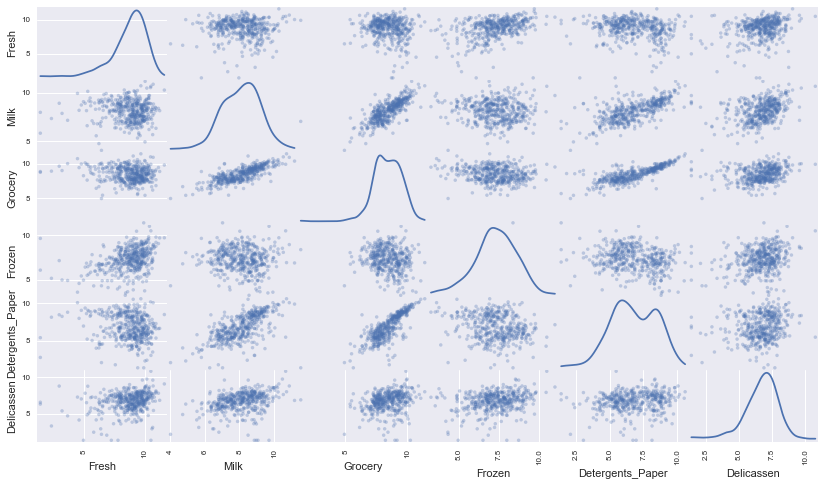

In [6]:
pd.scatter_matrix(data_fs, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

# 【課題】PCAの実行
PCAを行いましょう。分散説明率の累積が70%を超える数の主成分を選びます。処理を行ったら、data_pcaに格納してください。

array([0.44374606, 0.72041888, 0.83551768, 0.93140925, 0.97714523,
       1.        ])

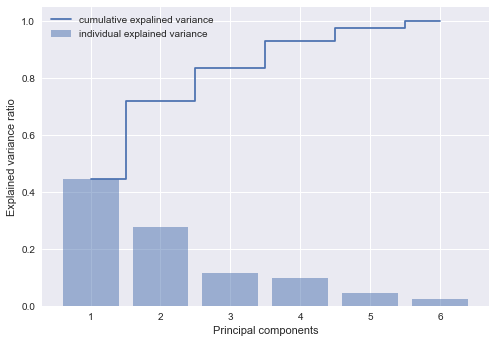

In [7]:
#data_fsに対しPCAを行い分散説明率の累積を確認
pca = PCA(n_components=None)
pca.fit_transform(data_fs)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

display(cum_var_exp)

plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [8]:
# 分散説明率が70%を超える数の主成分を選び、data_pcaに格納する
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_fs)
data_pca.shape

(440, 2)

## 【課題】なぜPCAを行うのか記述せよ
機械学習の前処理としてなぜPCAが必要なのかについて記述してください。

## 答え：
特徴量の個数を減らしてデータを扱いやすく本質を掴みやすくでき、次元の呪いに由来する過学習を防ぎ、計算量を減らすことができるから。これらの効果は一定程度情報を失うこととのトレードオフになるが、分散説明率が価値あるトレードになるかどうかの判断材料になる

## 【課題】クラスタリングとは何か記述せよ
クラスタリングについての説明を記述してください。その際、以下の観点を含めてください。
- いつ何に使うのか
- 階層的手法と非階層的手法との違い
- クラス分類（classification）との比較

## 答え：
### いつ何に使うのか
傾向や特徴はわからないが何かしらのグループ関係が潜在しているかもしれないデータを扱う場合に、その潜在しているグループ関係を導き出すために用いる
### 階層的手法と非階層的手法との違い
両方ともデータを特徴量空間上の各点と認識し、それらのユークリッド距離により関係を探る。  
階層的手法においては、はじめに全点を一つのクラスタと見立てて分割していく方法と、各点をそれぞれ一つずつのクラスタと見立てて結合していく２種類の方法がある。両者ともに分割と結合の経緯を追えるので、クラスタ形成の過程を可視化し易い。また、クラスタ数を予め指定する必要がない。  
非階層的手法においては、はじめにいくつかの中心点を仮定して、それぞれの中心点に最も近い各点をクラスタとする。そして、それらクラスタの本当の中心点を求め、新しい中心点に最も近い各点をクラスタとする。これを中心点が動かなくなるまで繰り返す。非階層手法との違いとしては次の2点である。クラスタ形成までの過程が可視化し辛い。最初に仮定する中心点の数が最終的なクラスタ数になるので、つまりクラスタ数を予め指定する必要がある
### クラス分類（classification）との比較
事前に分類先と分類方法が用意されていて、そこにデータを正しくグルーピングしていくのがクラス分類。一方クラスタリングの場合には、分類先と分類方法は用意されておらず、機械がデータの状況から機械的にグルーピングしていく

## 【課題】樹状図を描く
まずは階層的手法を使い、樹状図を描いてみます。手法はいくつもありましたが、ward法が良いでしょう

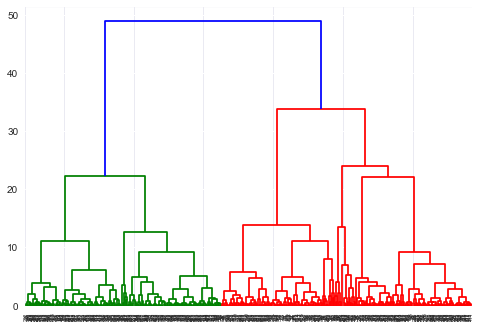

In [9]:
#樹状図を描くコードを記述
row_clusters = linkage(pdist(data_pca, metric='euclidean'), method='ward')
row_dender = dendrogram(row_clusters)
plt.show()

## 【課題】k-meansにおけるkの値の検討
クラスタリングはk-meansが定石です。まずはクラスタ数kの値を検討します。
まずはそのためのコードを記述し、その後選んだkの値と、それに決めた理由を記述してください。

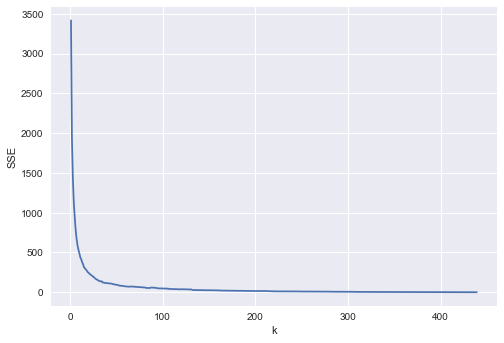

In [10]:
#クラスタ数を検討するためのコードを記述
SSE = []

for i in range(1, 440):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, 
                random_state=0)
    km.fit(data_pca)
    SSE.append(km.inertia_)

plt.plot(range(1,440), SSE)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

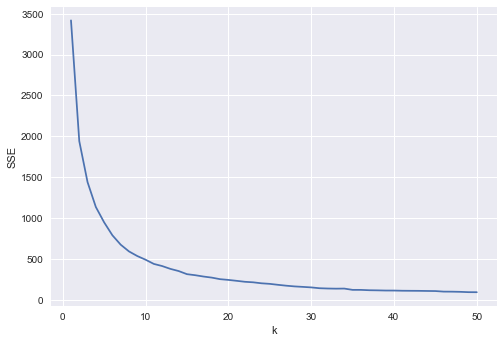

In [11]:
#クラスタ数を検討するためのコードを記述
SSE = []

for i in range(1, 51):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, 
                random_state=0)
    km.fit(data_pca)
    SSE.append(km.inertia_)

plt.plot(range(1, 51), SSE)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

### 選んだkの値
k = 3
### それに決めた理由
横軸にクラスタ数、縦軸にクラスタの中心点とクラスタの各点との距離の和であるクラスタ内誤差平方和を示すエルボー図を２回作成した。エルボー図の横軸右手側に進むほど、つまりクラスタ数が増えるほど、縦軸方向のクラスタ内誤差平方和は小さくなる。最小値はクラスタ数が今回のデータ数である４４０になる０である。  
１回目のエルボー図は、クラスタ数を最小の１から最大の４４０までを表示したが、目視できる限り、縦軸方向の顕著な落ち込みはクラスタ数の１から５０の間にあるように見える。このため、クラスタ数を１から５０の間に設定した２回目のエルボー図を作成した。  
２回目のエルボー図は、目視できる限り、１から１０の間で急激に落ち込み、１０から５０までの間を比較的緩やかに加工しているように見える。  
直感的には、クラスタ数３０あたりで下降が収束しているとも見えるが、今回の課題の題意である「卸売業者に対して有益な情報を報告」することを考えると、３０個は説明量として多く、下降が緩やかな分、必要以上に細かな説明になるようにも思われる。よってここでは、説明量としておおよそ目処が立ち、かつ、下降が急激で大枠を捉えた説明ができそうな値として、クラスタ数を3と決定した。

## 【課題】k-meansの実行

In [12]:
#k-meansを行うコードを記述
km = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, 
            random_state=0)
y_km = km.fit_predict(data_pca)
y_km.shape

(440,)

## 【課題】クラスタリングの可視化
PCAにより特徴量は可視化可能な次元に落ちているはずです。可視化することで分かってくることもあります。散布図を描き、クラスタ毎に色分けしましょう。中心点（セントロイド）もプロットしてみます。

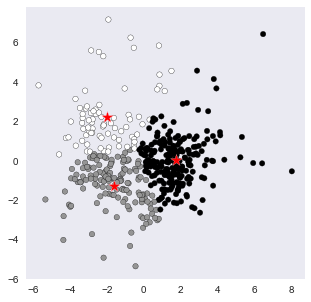

In [13]:
#散布図を描くコードを記述
plt.figure(figsize =(5,5))
plt.scatter(data_pca[:,0], data_pca[:,1], c=y_km , marker='o', s=30, edgecolors="black")

#中心点もプロットする
for i, xy in enumerate(km.cluster_centers_):
    plt.scatter(xy[0], xy[1], c='red' ,marker='*', s=150, edgecolors="pink")
    
plt.grid()
plt.show()

## 【課題】既知のグループとの比較
ChannelとRegionというグループ分けが元々存在していました。今回作ったクラスタと、それらとを比較してみましょう。
比較に使ったコードと、どのような結果だったかの説明を記述してください。

2    218
1    143
0     79
Name: y, dtype: int64

Region      1                 2                 3                  All
y           0     1     2     0     1     2     0      1      2       
Channel                                                               
1         8.0  13.0  38.0   2.0   3.0  23.0  21.0   36.0  154.0  298.0
2         8.0   9.0   1.0   8.0  10.0   1.0  32.0   72.0    1.0  142.0
All      16.0  22.0  39.0  10.0  13.0  24.0  53.0  108.0  155.0  440.0

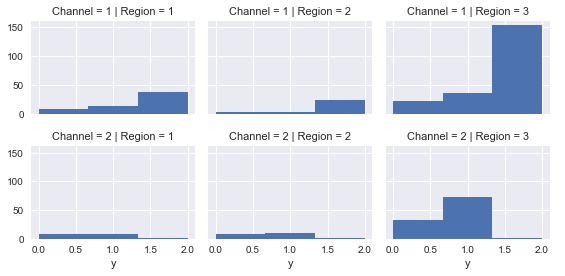

In [14]:
#比較に使ったコードを記述

# データ準備
channel_region_df = data_original[['Channel', 'Region']]
data_pca_df = pd.DataFrame(data_pca, columns=['x1', 'x2'])
y_km_df = pd.DataFrame(y_km, columns=['y'])
c_r_y_compare = pd.concat([channel_region_df, data_pca_df, y_km_df], axis=1)

# 各クラスタの構成数を表示
display(c_r_y_compare['y'].value_counts())

# Channel　× Regionで、各クラスタの構成数を表示
display(pd.pivot_table(
    c_r_y_compare, index='Channel', columns=['Region', 'y'], values='x1', aggfunc='count', 
    margins=True))

# Channel　× Regionで、各クラスタの構成を視覚化
grid = sns.FacetGrid(c_r_y_compare, col='Region', row='Channel', size=2.0, aspect=1.3)
grid.map(plt.hist, 'y', bins=3)
grid.add_legend()

## 説明
上述の通り今回のクラスタリングでは3種類のクラスタを得た。ここでそれぞれを便宜的にクラスタ0顧客、クラスタ1顧客、クラスタ2顧客と呼ぶこととする。  

- 顧客が「Hotel/Restaurant/Café」(1)の場合  
どの地域でもクラスタ2顧客が多く、クラスタ0顧客とクラスタ1顧客が少なくなっている。特に地域がOther Region(3)では、クラスタ2顧客が154件と最多であり全データ440件のおよそ1/3を占めている。地域がOporto(2)では、クラスタ0顧客が2件でクラスタ1顧客が3件と特に少なくなっている  


- 顧客が「Retail」(2)の場合  
どの地域でもクラスタ2顧客が1件のみと極めて少なくなっている。 地域がOther Region(3)では、クラスタ0顧客が32件でクラスタ1顧客が72件といずれも最多である。しかし他のリージョンでは、クラスタ0顧客もクラスタ2顧客も、「Hotel/Restaurant/Café」(1)の場合と同水準の少なさである

## 【課題】卸売業者への報告
クラスタリングを行ったことを元に、卸売業者に対して有益な情報を報告してください。クラスタリングについては詳しくない卸売業者の経営陣に説明するような平易な書き方を心がけてください。  
- （ヒント１）  
既知のグループとの比較結果は報告に使えるはずです。
- （ヒント２）  
data_originalに対してy_kmごとの要約統計量を見てみましょう。groupbyを使うのがおすすめです。新しく合計金額を特徴量として入れるのも良いでしょう。
- （ヒント３）  
クラスタ、k-menasなどの言葉は使わないで説明してみましょう。

### ①顧客タイプの分類
顧客をそれぞれの特徴から3つのタイプに分類する

#### 良顧客タイプ
- 全体に占める割合は約18%
- 「Retail」で比較的多く、「Other Region」で特に多い
- 合計金額の平均値では2位
- 全体的な消費は中量
- 冷凍品の消費が極めて少量、かつ、極めて低額
- 生鮮品、惣菜の消費が少量、かつ、低額
- 日用品、洗剤・紙製品の消費が多量、かつ、低額・中額が中心。高額もある

#### 優良顧客タイプ 
- 全体に占める数は約32%
- 「Retail」で比較的多く、「Other Region」で特に多い
- 合計金額の平均値では1位
- 全体的な消費は多量
- 冷凍品、洗剤・紙製品、惣菜で、低額が中心。高額もある
- 生鮮品、乳製品、日用品で、低額と中額が中心。高額もある

#### 準良顧客タイプ　　
- 全体に占める数は約50%
- 「Hotel/Restaurant/Café」のみに存在し、「Other Region」で特に多い
- 合計金額の平均値では3位
- 全体的な消費は低額
- 洗剤・紙製品の消費が極めて少量、かつ、極めて低額
- 乳製品、日用品、惣菜の消費が少量、かつ、低額
- 生鮮品、冷凍品の消費が多量、かつ、低額と中額が中心

### ②地域と業種における各顧客タイプごとの合計金額分布
地域と業種で顧客タイプごとの合計金額分布をみる。以降では、便宜的に業種「ホテル・レストラン・カフェ」をHorecaと略称する

#### リスボンのHoreca
準良顧客タイプは最も多数で低額である。良顧客タイプは少数で低額である。優良顧客タイプは少数だが中額である
#### ポルトのHoreca
準良顧客タイプは最も多数で低額である。良顧客タイプは目視できないほど少数である。優良顧客タイプは少数だが低中額と高額がある
#### その他の地域のHoreca
準良顧客タイプは多数で低額である。良顧客タイプは少数で低額である。優良顧客タイプは多数で低中額が中心で、高額もある
#### リスボンの小売店
準良顧客タイプは現れない。良顧客タイプは少数で低額である。優良顧客タイプは少数で中額である
#### ポルトの小売店
準良顧客タイプは現れない。良顧客タイプは少数で低額が中心で、中額もある。優良顧客タイプは少数で低額である
#### その他の地域の小売店
準良顧客タイプは現れない。良顧客タイプは少数で低額が中心である。優良顧客タイプは多数で低額が中心で、中額も高額もある

## ③上述①②を踏まえた卸売業者が取るべき戦略
顧客タイプと、地域と業種における各顧客タイプごとの合計金額分布を踏まえた卸売業者が取るべき戦略を示す

### 基本方針
- 顧客タイプについて、「準良→良→優良」の方向にそれぞれ格上げていくことが望ましいが、その一方で格下げ・客離れを起こさずそれぞれに現在の格を維持させる。また、新規顧客開拓も行う  
- 輸送について、円滑な業務遂行とコスト削減のため、品目と地域は分散させず極力集中させる  

### 地域別の戦略
- リスボンとポルトにおいては、Horecaの準良顧客の多さと小売の準良顧客がいないことから、準良顧客を開拓する下地はあると考えられる。また、全体的な良顧客・優良顧客の少なさから、優良顧客の全方位的なニーズに応えるよりも、準良顧客開拓と、現在多勢を占める準良顧客を良顧客に育てることに経営資源を集中したい。したがって、リスボンとポルトでは、準良顧客開拓を狙って生鮮品と冷凍品の入荷、準良顧客の良顧客化を狙って日用品と洗剤・紙製品の入荷を強化する。これらに注力する一方で優良顧客にも配慮し、その他の商品については現状維持とする  


- その他の地域においては、リスボンとポルトと同様にHorecaの準良顧客の多さと小売の準良顧客がいないことから、準良顧客を開拓する下地はあると考えられる。ただし、ここでは優良顧客と良顧客が多いため、優良顧客の全方位的なニーズに応えることで、「準良→良→優良」の格上げ、及び、それぞれの格の維持という両得を狙った全方位戦略が有効と考えられる。そこまでの経営資源を割けない場合においては、リスボンとポルトでの戦略に沿って、準良顧客開拓と、準良顧客を良顧客に育てることに注力する。また、その他の地域という括りが大きすぎて、品目と地域は分散させず極力集中させるという基本戦略遂行に支障があるため、早急に詳しい地域データを元に顧客データを収集し直すべきである

### 業種別の戦略
- Horecaにおいては、多勢を占める準良顧客を維持・拡大し、また、現在数が少ない良顧客に育てるために、リスボンとポルトにおける地域別の戦略が有効と考えられる  


- 小売においては、良顧客・優良顧客の入り口にするためにも顧客数確保のためにも、現在存在しない準良顧客を開拓し、良顧客を優良顧客に育てる工夫が必要である。ここではしかし、小売における準良顧客は、Horecaにおけるそれとは異なる傾向を示す未知のタイプである可能性が高い。当面は、全ての格に対する全方位戦略を取りつつ、小売における準良顧客の調査を怠らないことが肝要と考える

In [15]:
# データ準備
y_km_df = pd.DataFrame(y_km, columns=['y'])
original_y = pd.concat([data_original, y_km_df], axis=1)
# 合計金額追加
original_y['total'] = (
    original_y['Fresh'] + original_y['Milk'] + original_y['Grocery'] + original_y['Frozen'] + 
    original_y['Detergents_Paper'] + original_y['Delicassen'])

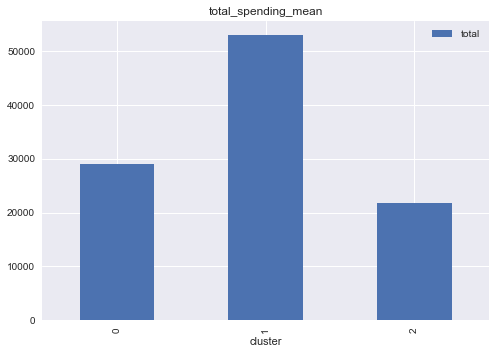

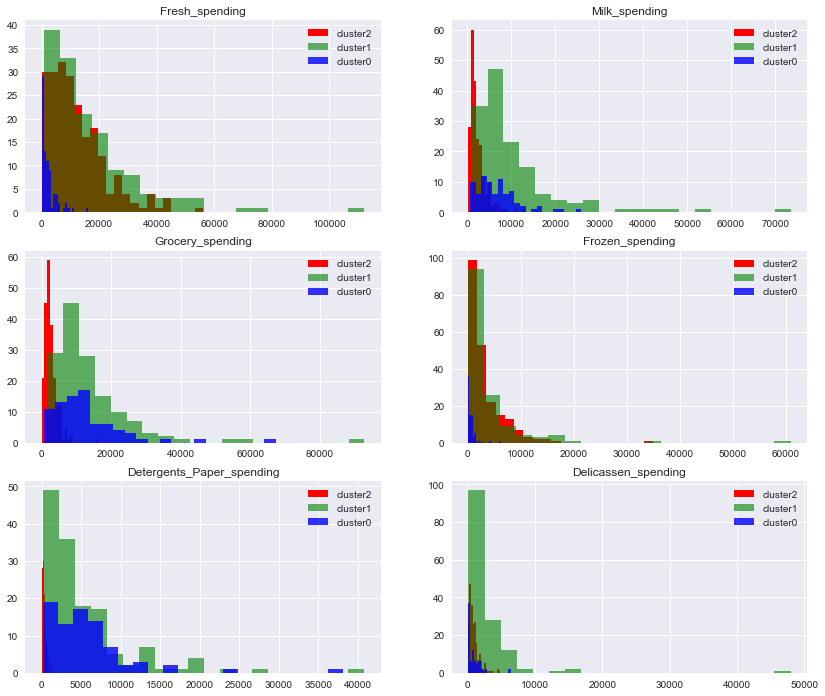

In [16]:
# 合計金額の平均を、クラスタ別に棒グラフで表示
original_y.groupby('y', as_index=False).mean().plot.bar(x='y', y='total')
plt.xlabel('cluster')
plt.title('total_spending_mean')

# 各カテゴリ毎の消費額を、クラスタ別にヒストグラムで表示
for index, category in enumerate([
    'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']):
    fig = plt.figure(6, figsize=(14, 12))
    ax = fig.add_subplot(3, 2, index+1)
    ax.hist(original_y.loc[original_y['y']==2, category], color='r', alpha=1.0, bins=20)
    ax.hist(original_y.loc[original_y['y']==1, category], color='g', alpha=0.6, bins=20)
    ax.hist(original_y.loc[original_y['y']==0, category], color='b', alpha=0.8, bins=20)
    plt.legend(['cluster2', 'cluster1', 'cluster0'])
    plt.title(category + '_spending')

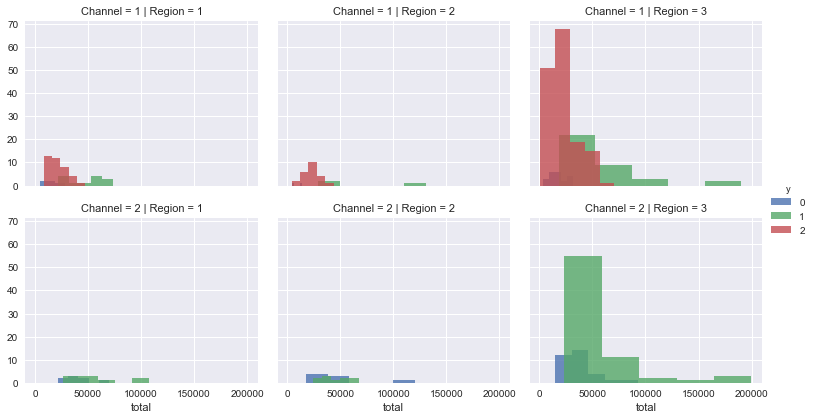

In [17]:
# Channel　× Regionで、合計金額を、クラスタ別にヒストグラムで表示
grid = sns.FacetGrid(original_y, col='Region', row='Channel', hue='y', size=3.0, aspect=1.2)
grid.map(plt.hist, 'total', alpha=0.8, bins=5)
grid.add_legend()